# Project 2 - Credit Risk
Wenkai Fu \
1005787347

## Simulation of future portfolio value using multivariate Gaussian distribution and Gaussian copula with correlation of 0.5 dependency structure


In [2]:
!pip install copulas -q
import numpy as np
import pandas as pd
from scipy.stats import t, norm, multivariate_normal
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 871.3 kB/s eta 0:00:00


In [3]:
# Model Setup
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]
Prob = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100
CumProb = np.cumsum(Prob[::-1])[::-1]
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])
df = pd.DataFrame({'Bond Rating': BondRating, 'Probability': Prob, 'CumProb': CumProb, 'Transition Value': BondValue})
df

,Bond Rating,Probability,CumProb,Transition Value
0,AAA,0.0002,1.0000,109.37
1,AA,0.0033,0.9998,109.19
2,A,0.0595,0.9965,108.66
3,BBB,0.8693,0.9370,107.55
4,BB,0.0530,0.0677,102.02
5,B,0.0117,0.0147,98.10
6,C,0.0012,0.0030,83.64
7,Default,0.0018,0.0018,51.13


In [4]:
# Calculate the Z-value under Standard normal distribution

ZDefault = norm.ppf(CumProb[7])
ZC = norm.ppf(np.sum(CumProb[6]))
ZB = norm.ppf(np.sum(CumProb[5]))
ZBB = norm.ppf(np.sum(CumProb[4]))
ZBBB = norm.ppf(np.sum(CumProb[3]))
ZA = norm.ppf(np.sum(CumProb[2]))
ZAA = norm.ppf(np.sum(CumProb[1]))
ZAAA = norm.ppf(np.sum(CumProb[0]))

Z = np.array([ZAAA, ZAA, ZA, ZBBB, ZBB, ZB, ZC, ZDefault])
df['Z'] = Z
df

,Bond Rating,Probability,CumProb,Transition Value,Z
0,AAA,0.0002,1.0000,109.37,inf
1,AA,0.0033,0.9998,109.19,3.540084
2,A,0.0595,0.9965,108.66,2.696844
3,BBB,0.8693,0.9370,107.55,1.530068
4,BB,0.0530,0.0677,102.02,-1.493142
5,B,0.0117,0.0147,98.10,-2.178081
6,C,0.0012,0.0030,83.64,-2.747781
7,Default,0.0018,0.0018,51.13,-2.911238


In [114]:
# Simulation

N = 1000000
default_rho = 0.5
CDEP = np.array([[1, default_rho], [default_rho, 1]])

# A. Multivariate Gaussian distribution with a correlation of 0.5
ZDEP_multi = multivariate_normal(mean=[0, 0], cov=CDEP).rvs(N)


# B. Gaussian copula with correlation of 0.5
UDEP_multi = norm.cdf(ZDEP_multi)

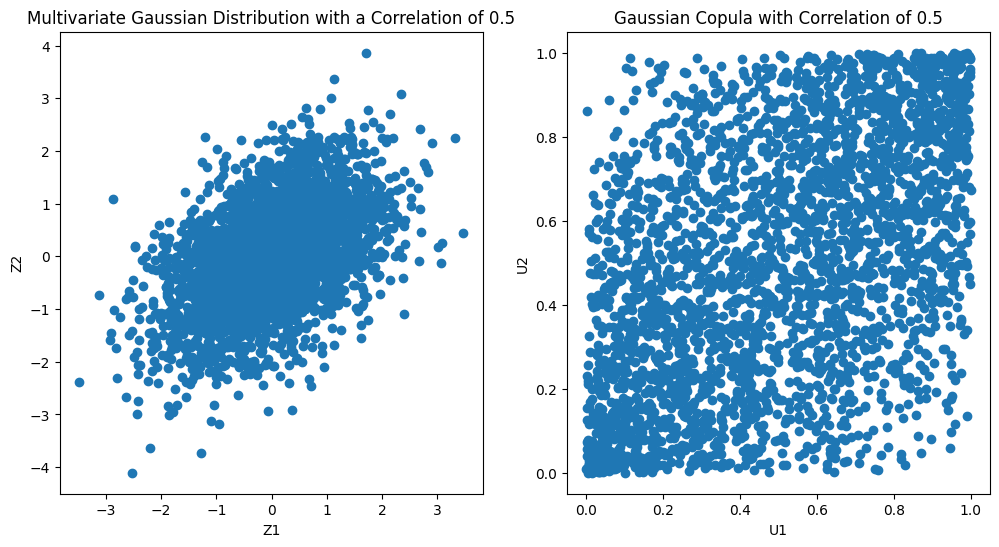

In [115]:
# Visualization of two dependency structure
plt.figure(figsize = (12,6))
sample = 3000
# Plot for multivariate Gaussian Distribution
plt.subplot(1,2,1)
plt.scatter(ZDEP_multi[:sample, 0], ZDEP_multi[:sample, 1])
plt.title('Multivariate Gaussian Distribution with a Correlation of 0.5')
plt.xlabel('Z1')
plt.ylabel('Z2')

# Plot for Gaussian copula
plt.subplot(1,2,2)
# plt.scatter(x=samples_dep[0], y=samples_dep[1])
plt.scatter(UDEP_multi[:sample, 0], UDEP_multi[:sample, 1])
plt.title('Gaussian Copula with Correlation of 0.5')
plt.xlabel('U1')
plt.ylabel('U2')

plt.show()

In [138]:
#@title Estimate the Probability of Default

Nbonds = 2
Currentvalue_bonds = np.dot(Prob, BondValue)
Currentvalue_portfolio = Currentvalue_bonds * Nbonds
print(f"Currentvalue_bonds: {Currentvalue_bonds}")
print(f"Currentvalue_portfolio: {Currentvalue_portfolio}")

# Storage
Futurevalue_portfolio_A = np.full((N, Nbonds), np.nan)
Futurevalue_portfolio_B = np.full((N, Nbonds), np.nan)

# Z-boundaries
CumProbabilityBoundary = np.append(CumProb, 0)

# A. Multivariate Normal approach

for i in range(N):
  IZ1 = np.argmax(Z <= ZDEP_multi[i,0])
  IZ2 = np.argmax(Z <= ZDEP_multi[i,1])

  Futurevalue_portfolio_A[i, :] = [BondValue[min(IZ1, 8)-1], BondValue[min(IZ2, 8)-1]]

# B. Copula approach

for i in range(N):
  IZ1 = np.argmax(CumProbabilityBoundary <= UDEP_multi[i, 0])
  IZ2 = np.argmax(CumProbabilityBoundary <= UDEP_multi[i, 1])

  Futurevalue_portfolio_B[i, :] = [BondValue[min(IZ1, 8)-1], BondValue[min(IZ2, 8)-1]]


# Find Porfolio PnL
PortfolioDEP_A = np.sum(Futurevalue_portfolio_A, axis=1) - Currentvalue_portfolio
print(f"PortfolioDEP_A: {PortfolioDEP_A}")

PortfolioDEP_B = np.sum(Futurevalue_portfolio_B, axis=1) - Currentvalue_portfolio
print(f"PortfolioDEP_B : {PortfolioDEP_B}")

ECL_A = np.mean(PortfolioDEP_A)
ECL_B = np.mean(PortfolioDEP_B)
print(f"ECL_A: {ECL_A}")
print(f"ECL_B: {ECL_B}")


# 99% quantile
DEPVAR99_A = np.percentile(PortfolioDEP_A, 1)
print(f"DEPVAR99_A: {DEPVAR99_A}")

DEPVAR99_B = np.percentile(PortfolioDEP_B, 1)
print(f"DEPVAR99_B: {DEPVAR99_B}")

Currentvalue_bonds: 107.087918
Currentvalue_portfolio: 214.175836
PortfolioDEP_A: [ 0.924164  2.034164  0.924164 ...  0.924164  0.924164 -8.525836]
PortfolioDEP_B : [ 0.924164  2.034164  0.924164 ...  0.924164  0.924164 -8.525836]
ECL_A: -0.0001773200000110984
ECL_B: -0.0001773200000110984
DEPVAR99_A: -14.055836
DEPVAR99_B: -14.055836


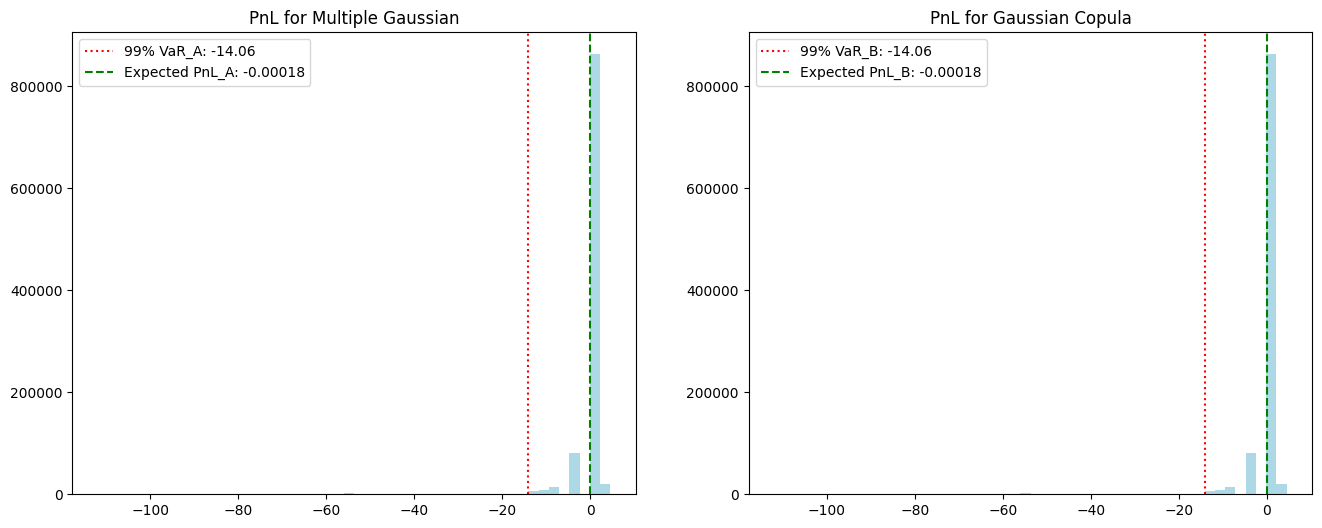

In [141]:
plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
plt.hist(PortfolioDEP_A, bins = 50, color = 'lightblue')
plt.axvline(DEPVAR99_A, color = 'red', linestyle = ':', label= f"99% VaR_A: {DEPVAR99_A:.2f}")
plt.axvline(ECL_A, color = 'green', linestyle = '--', label= f"Expected PnL_A: {ECL_A:.5f}")
plt.title("PnL for Multiple Gaussian")
plt.legend()

plt.subplot(1,2,2)
plt.hist(PortfolioDEP_B, bins = 50, color = 'lightblue')
plt.axvline(DEPVAR99_B, color = 'red', linestyle = ':', label= f"99% VaR_B: {DEPVAR99_B:.2f}")
plt.axvline(ECL_B, color = 'green', linestyle = '--', label= f"Expected PnL_B: {ECL_B:.5f}")
plt.title("PnL for Gaussian Copula")
plt.legend()

plt.show()

### For multiple Gaussian dependency structure, the expected PnL is approximately **-0.00018**. And the 99% VaR is **14.06**. For the Gaussian Copula dependency structure, the expected value and 99% VaR are **-0.00018** and **14.06** separately, which are the same with the value of previous one.

### By comparing the value of A and B, both dependency structure are the same. Since both bonds have the same PD and LGD, it means that they have identical credit risk characteristics. This means they are equally likely to default, and in the event of default, they would incur the same percentage loss. Therefore, the credit risk profiles of the two bonds are essentially identical.

### Another reason might be that the correlation is relatively high for dependency structure, it means that they tend to move in sync with each other, especially during credit events. In such a case, it's not surprising that you are getting similar PnL and VaR results for both bonds because their credit events are highly correlated.

